In [19]:
import requests
import json

url = '10.168.20.20:5010'
entries = ['5b491e3dd7f17a0025e48d76']
rolesa = '5afdb8cf93beb10025c13f4f'

In [20]:
pipeline = [
    {'$match': {'_id': {'$in': entries}, 'roles._id': rolesa}},
    {
        '$graphLookup': {
            'from': 'applications',
            'startWith': '$deps._id',
            'connectFromField': 'deps._id',
            'connectToField': '_id',
            'as': 'nodes',
            'maxDepth': 10,
            'depthField': 'steps'
        }
    },
    {'$project': {
                    'name': 1, 'family': 1, 
                    'deps._id': 1, 'deps.endpoint': 1, 
                    'nodes._id': 1, 'nodes.deps': 1, 'nodes.name': 1, 'nodes.family': 1, 'nodes.servers': 1
                 }
    }
];

jpipeline = json.dumps(pipeline)

data = requests.post('http://%s/aggregate' % url, json={'entity': 'applications', 'pipeline': jpipeline})
data = data.json()

In [21]:
import sys
import os
cwd = os.getcwd()
spltted = cwd.split('/')[:-1]
sys.path.append('/'.join(spltted))

import networkx as nx
from app.services.gridOrchestrator import GridOrchestrator
from app.libs.network.baseNetwork import BaseNetwork
from app.libs.histograms.histogram import Histogram
from app.libs.histograms.grid import GridHistogram

from svgwrite import Drawing

network = BaseNetwork()
network.make(data.get('items')).get_graph()

In [22]:
class DrawArea(object):
    def __init__(self, off, size, hist, nmax):
        self._off = off
        self._size = size
        self._hist = hist
        self._nmax = nmax

    def cal_area(self, n, pointer):
        return (n * self._size[pointer]) + (n * self._off[pointer])

    def area(self):
        area_y = self.cal_area(self._nmax, 1)
        area_x = self.cal_area(max(self._hist, key=int) + 1, 1)
        return (area_x, area_y)

class DefsSVG(object):
    def __init__(self, draw):
        self.dwg = draw

    def app(self, pos, title, size=(20, 20), unit="px"):
        opts = {
            'size': ("%s%s" % (size[0], unit), "%s%s" % (size[1], unit)),
            'stroke_width': "1",
            'stroke': "black",
            'fill': "rgb(255,255,0)"
        }

        self.add(self.dwg.rect(insert=pos, **opts))
        self.add(self.dwg.text(title, insert=(pos[0], pos[1] + 10), fill='red'))

    def line(self, cx, cy):
        opts = {
            'stroke_width': "1",
            'stroke': "black",
            'fill': "rgb(0,0,0)"
        }

        self.add(self.dwg.line(start=cx, end=cy, **opts))

    def add(self, svg):
        self.dwg.add(svg)

In [23]:
class DrawTemplateSVG(object):
    def __init__(self, hist, nmax, darea=DrawArea, defs=DefsSVG):
        self._off = (40, 40)
        self._size = (20, 20)

        self._hist = hist
        self._nmax = nmax

        self._area = darea(self._off, self._size, hist, nmax).area()

        self.dwg = Drawing('test.svg', size=self._area)
        self._grid_defs = defs(self.dwg)

    def draw_app(self, pos, item):
        label = item[3].get('name')
        size = item[2]
        
        print(label, size)
        
        pos = self.cal_off(pos, size)
        self._grid_defs.app(pos, label, self._size)

    def draw_connect(self, pos1, pos2, w1, w2, size1, size2):
        pos1 = self.cal_pos_line(pos1, w1, self._size[0])
        pos2 = self.cal_pos_line(pos2, w2)

        self._grid_defs.line(pos1, pos2)

    def cal_off(self, pos, size):
        w = pos[0]
        
        x = self.cal_offx(pos[0], w)
        y = self.cal_offy(pos[1], w, size)

        return (x, y)

    def cal_offy(self, y, w, size):
        off = 0
        
        if size > 1:
            off = ((size-1) * self._size[1]) + ((size-2) * self._off[1]) / 2
    
        return (y * self._off[1]) + (y * self._size[1]) + off

    def cal_offx(self, x, w):
        return (x * self._off[0]) + (x * self._size[0])

    def cal_pos_line(self, pos, w, suff_x=0):
        apos = self.cal_off(pos, w)
        y = apos[1] + (self._size[1] / 2)
        x = apos[0] + suff_x

        return (x, y)

    def save(self):
        self.dwg.save()
        return self.dwg.get_xml()

class DrawLayout(object):
    def __init__(self, grid, index, gridhist=GridHistogram, draw=DrawTemplateSVG):
        
        self._grid = grid
        self._index = index
        
        GridHistogram = gridhist(self._grid)
        self._nmax = GridHistogram.max_value()
        self._hist = GridHistogram.get_counter()
        
        self.drawer = draw(self._hist, self._nmax)

    def draw_nodes(self):
        data = self._grid
        for col_k, columm in data.items():
            for line_k, label in columm.items():
                if label in self._index:
                    item = self._index[label]
                    
                    self.drawer.draw_app((col_k, line_k), item)
        
        return self
    
    def draw_connections(self, edges):
        for edge in edges:
            pos = []
            w = []
            size = []
            
            for i in range(2):
                ipos = self._index[edge[i]]
                pos.append(ipos)
                w.append(ipos[0])
                size.append(ipos[2])

            self.drawer.draw_connect(*pos, *w, *size)
            
        return self
    
    def save(self):
        return self.drawer.save()

-------------------------
akamai 7
app1 1
app5 1
app2 2
app3 3
sub2 1
sub1 1
root 3
roo1 1
root3 1
root2 1


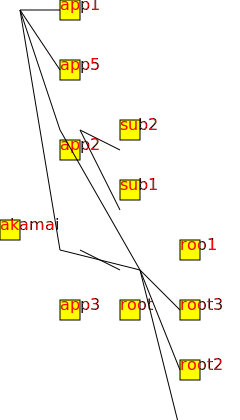

In [24]:
from IPython.display import SVG, display

print("-------------------------")
Orchestration = GridOrchestrator(network.graph)
Orchestration.create(entries)

Layout = DrawLayout(Orchestration.get_grid().get_grid(), Orchestration.get_grid().get_index())
Layout.draw_nodes()
Layout.draw_connections(network.graph.edges(data='endpoint'))
Layout.save()
   
display(SVG(filename='test.svg'))